In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
import pickle
import mlflow
import warnings
import boto3
warnings.filterwarnings('ignore')

In [2]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("loan-prediction-experiment")
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'http://127.0.0.1:5000'


In [3]:
df = pd.read_parquet('../data/loans_full_schema_clean.parquet')

In [4]:
df.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,delinq_2y,months_since_last_delinq,earliest_credit_line,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
1,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,0,38.0,2001,...,C3,Mar-2018,0,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
2,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,0,34.0,1996,...,C1,Feb-2018,0,whole,Cash,4651.37,499.12,348.63,150.49,0.0
3,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,0,28.0,2006,...,D1,Feb-2018,0,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
4,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,0,34.0,2007,...,A3,Jan-2018,0,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
5,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,0,34.0,2008,...,C3,Mar-2018,0,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


In [5]:
df['loan_status'].value_counts()

loan_status
0    9993
1       7
Name: count, dtype: int64

In [6]:
count_majority_class = df['loan_status'].value_counts()[0]

count_minority_class = df['loan_status'].value_counts()[1]

sum_negative_instances = count_majority_class
sum_positive_instances = count_minority_class

scale_pos_weight = sum_negative_instances / sum_positive_instances

print("Scale positive weight:", scale_pos_weight)

total_samples = count_majority_class + count_minority_class

n_classes = 2

weight_majority_class = total_samples / (n_classes * count_majority_class)
weight_minority_class = total_samples / (n_classes * count_minority_class)

class_weights = {0: weight_majority_class, 1: weight_minority_class}

print("Weight for the majority class (Not Charged Off: 0):", weight_majority_class)
print("Weight for the minority class (Charged Off: 1):", weight_minority_class)


Scale positive weight: 1427.5714285714287
Weight for the majority class (Not Charged Off: 0): 0.5003502451716202
Weight for the minority class (Charged Off: 1): 714.2857142857143


In [7]:
X = df.drop(columns=['loan_status'])
y = df['loan_status']

def train_val_test_split(X, y, train_size, val_size, test_size, random_state):
    assert train_size + val_size <= 1, "train_size + val_size should be less than or equal to 1."

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = test_size, random_state=random_state, stratify=y)
    relative_train_size = train_size / (val_size + train_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      train_size = relative_train_size, test_size = 1-relative_train_size, random_state=random_state, stratify=y_train_val)
    return X_train, X_val, X_test, y_train, y_val, y_test;

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=42)

In [8]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(8000, 51) (1000, 51) (1000, 51) (8000,) (1000,) (1000,)


In [9]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [10]:
numerical_transformer = StandardScaler(with_mean=False)  # Sparse input needs with_mean=False
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = make_column_transformer(
    (numerical_transformer, numerical_features),
    (categorical_transformer, categorical_features)
)

In [11]:
#logistic regression
log_reg = LogisticRegression(class_weight=class_weights, random_state=42)

pipeline = make_pipeline(preprocessor, log_reg)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(with_mean=False),
                                                  ['emp_length',
                                                   'annual_income',
                                                   'debt_to_income',
                                                   'delinq_2y',
                                                   'months_since_last_delinq',
                                                   'earliest_credit_line',
                                                   'inquiries_last_12m',
                                                   'total_credit_lines',
                                                   'open_credit_lines',
                                                   'total_credit_limit',
                                                   'total_credit_utilized',
                                                   'num_collection...
                                                   'tax_liens', ...]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['emp_title', 'state',
                                                   'homeownership',
                                                   'verified_income',
                                                   'loan_purpose',
                                                   'application_type', 'grade',
                                                   'sub_grade', 'issue_month',
                                                   'initial_listing_status',
                                                   'disbursement_method'])])),
                ('logisticregression',
                 LogisticRegression(class_weight={0: 0.5003502451716202,
                                                  1: 714.2857142857143},
                                    random_state=42))])

In [12]:
y_preds = pipeline.predict(X_val) 
f1 = f1_score(y_val, y_preds)
f1

0.4

In [13]:
print("training accuracy: ", pipeline.score(X_train, y_train))
print('')
y_preds = pipeline.predict(X_val)
print(classification_report(y_val, y_preds))

training accuracy:  0.9975

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       999
           1       0.25      1.00      0.40         1

    accuracy                           1.00      1000
   macro avg       0.62      1.00      0.70      1000
weighted avg       1.00      1.00      1.00      1000



In [14]:
y_preds_prob = pipeline.predict_proba(X_val)[:, 1]  # Use the probabilities for the positive class
print('Area Under Curve')
print(roc_auc_score(y_val, y_preds_prob))
print('')


Area Under Curve
0.998998998998999



In [15]:
rf_clf = RandomForestClassifier(class_weight=class_weights, random_state=42)

pipeline = make_pipeline(preprocessor, rf_clf)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(with_mean=False),
                                                  ['emp_length',
                                                   'annual_income',
                                                   'debt_to_income',
                                                   'delinq_2y',
                                                   'months_since_last_delinq',
                                                   'earliest_credit_line',
                                                   'inquiries_last_12m',
                                                   'total_credit_lines',
                                                   'open_credit_lines',
                                                   'total_credit_limit',
                                                   'total_credit_utilized',
                                                   'num_collection...
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['emp_title', 'state',
                                                   'homeownership',
                                                   'verified_income',
                                                   'loan_purpose',
                                                   'application_type', 'grade',
                                                   'sub_grade', 'issue_month',
                                                   'initial_listing_status',
                                                   'disbursement_method'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight={0: 0.5003502451716202,
                                                      1: 714.2857142857143},
                                        random_state=42))])

In [16]:
y_preds = pipeline.predict(X_val) 
f1 = f1_score(y_val, y_preds)
f1

0.0

In [17]:
print("training accuracy: ", pipeline.score(X_train, y_train))
print('')
y_preds = pipeline.predict(X_val)
print(classification_report(y_val, y_preds))

training accuracy:  1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       999
           1       0.00      0.00      0.00         1

    accuracy                           1.00      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       1.00      1.00      1.00      1000



In [18]:
xgb_clf = xgb.XGBClassifier(scale_pos_weight=class_weights[1], random_state=42)
pipeline = make_pipeline(preprocessor, xgb_clf)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(with_mean=False),
                                                  ['emp_length',
                                                   'annual_income',
                                                   'debt_to_income',
                                                   'delinq_2y',
                                                   'months_since_last_delinq',
                                                   'earliest_credit_line',
                                                   'inquiries_last_12m',
                                                   'total_credit_lines',
                                                   'open_credit_lines',
                                                   'total_credit_limit',
                                                   'total_credit_utilized',
                                                   'num_collection...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [19]:
y_preds = pipeline.predict(X_val) 
f1 = f1_score(y_val, y_preds)
f1

0.0

In [20]:
print("training accuracy: ", pipeline.score(X_train, y_train))
print('')
y_preds = pipeline.predict(X_val)
print(classification_report(y_val, y_preds))

training accuracy:  0.999875

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       999
           1       0.00      0.00      0.00         1

    accuracy                           1.00      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       1.00      1.00      1.00      1000



In [27]:
# Define the hyperparameter space
space = {
    'logisticregression__C': hp.loguniform('logisticregression__C', np.log(0.01), np.log(100)),  # Regularization parameter
    'logisticregression__penalty': hp.choice('logisticregression__penalty', ['l1', 'l2']),  # Regularization type
    'logisticregression__class_weight': hp.choice('logisticregression__class_weight', [None, 'balanced', {0: weight_majority_class, 1: weight_minority_class}])
}

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "logistic_regression")
        mlflow.log_params(params)
        
        # Create the logistic regression model with the specified hyperparameters
        log_reg = LogisticRegression(solver='liblinear', random_state=42)
        
        # Create the pipeline
        pipeline = make_pipeline(preprocessor, log_reg)
        
        # Set the hyperparameters
        pipeline.set_params(**params)
        
        # Fit the pipeline on the training data
        pipeline.fit(X_train, y_train)
        
        # Make predictions on the validation set
        y_pred = pipeline.predict(X_val)
        
        # Calculate F1 score
        f1 = f1_score(y_val, y_pred)
        
        mlflow.log_metric("f1_score", f1)
        
    return {'loss': -f1, 'status': STATUS_OK}

# Create a Trials object to keep track of the results
trials = Trials()

# Find the best hyperparameters using Hyperopt
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████| 100/100 [00:45<00:00,  2.21trial/s, best loss: -1.0]


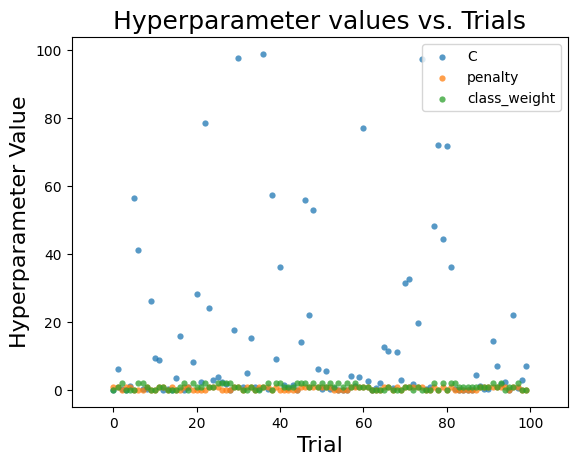

In [28]:
f, ax = plt.subplots(1)

# Extract hyperparameters and corresponding trial IDs from the trials object
xs = [t['tid'] for t in trials.trials]
ys_C = [t['misc']['vals']['logisticregression__C'][0] for t in trials.trials]
ys_penalty = [t['misc']['vals']['logisticregression__penalty'][0] for t in trials.trials]
ys_class_weight = [t['misc']['vals']['logisticregression__class_weight'][0] for t in trials.trials]

# Set x-axis limits to show 10 trials before and after the first and last trials, respectively
ax.set_xlim(xs[0] - 10, xs[-1] + 10)

# Create scatter plots for each hyperparameter
ax.scatter(xs, ys_C, s=20, linewidth=0.01, alpha=0.75, label='C')
ax.scatter(xs, ys_penalty, s=20, linewidth=0.01, alpha=0.75, label='penalty')
ax.scatter(xs, ys_class_weight, s=20, linewidth=0.01, alpha=0.75, label='class_weight')

# Set plot title and axis labels
ax.set_title('Hyperparameter values vs. Trials', fontsize=18)
ax.set_xlabel('Trial', fontsize=16)
ax.set_ylabel('Hyperparameter Value', fontsize=16)

# Show a legend for the different hyperparameters
ax.legend()

# Show the plot
plt.show()


Random Forest

In [85]:
# Define the hyperparameter space
space = {
    'randomforestclassifier__n_estimators': hp.choice('randomforestclassifier__n_estimators', [50, 100, 150]),
    'randomforestclassifier__max_depth': hp.choice('randomforestclassifier__max_depth', [None, 10, 20]),
    'randomforestclassifier__min_samples_split': hp.choice('randomforestclassifier__min_samples_split', [2, 5, 10]),
    'randomforestclassifier__class_weight': hp.choice('randomforestclassifier__class_weight', [None, 'balanced', {0: weight_majority_class, 1: weight_minority_class}])
}

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "random_forest")
        mlflow.log_params(params)
        
        # Create the random forest model with the specified hyperparameters
        rf_clf = RandomForestClassifier(random_state=42)
        
        # Create the pipeline
        pipeline = make_pipeline(preprocessor, rf_clf)
        
        # Set the hyperparameters
        pipeline.set_params(**params)
        
        # Fit the pipeline on the training data
        pipeline.fit(X_train, y_train)
        
        # Make predictions on the validation set
        y_pred = pipeline.predict(X_val)
        
        # Calculate F1 score
        f1 = f1_score(y_val, y_pred)
        
        mlflow.log_metric("f1_score", f1)
        
    return {'loss': -f1, 'status': STATUS_OK}

# Create a Trials object to keep track of the results
trials = Trials()

# Find the best hyperparameters using Hyperopt
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)


100%|██████████| 100/100 [01:13<00:00,  1.36trial/s, best loss: -0.0]


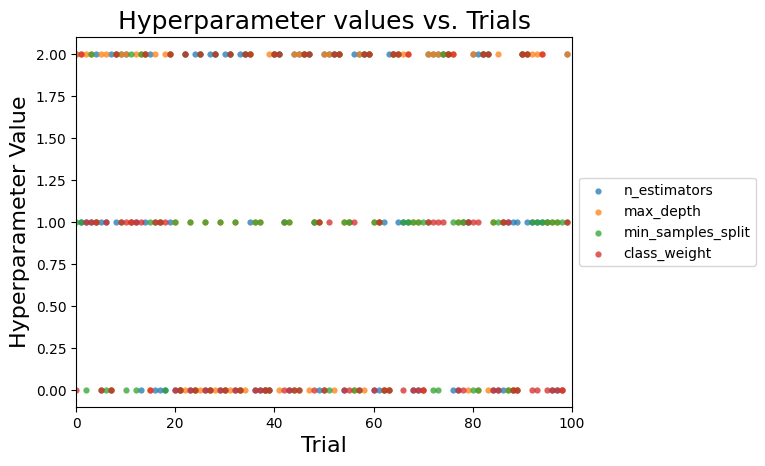

In [87]:
# Set up the figure and axis
f, ax = plt.subplots(1)

# Extract hyperparameters and corresponding trial IDs from the trials object
xs = [t['tid'] for t in trials.trials]
ys_n_estimators = [t['misc']['vals']['randomforestclassifier__n_estimators'][0] for t in trials.trials]
ys_max_depth = [t['misc']['vals']['randomforestclassifier__max_depth'][0] for t in trials.trials]
ys_min_samples_split = [t['misc']['vals']['randomforestclassifier__min_samples_split'][0] for t in trials.trials]
ys_class_weight = [t['misc']['vals']['randomforestclassifier__class_weight'][0] for t in trials.trials]

# Set x-axis limits to show all trials
ax.set_xlim(0, len(xs))

# Create scatter plots for each hyperparameter
ax.scatter(xs, ys_n_estimators, s=20, linewidth=0.01, alpha=0.75, label='n_estimators')
ax.scatter(xs, ys_max_depth, s=20, linewidth=0.01, alpha=0.75, label='max_depth')
ax.scatter(xs, ys_min_samples_split, s=20, linewidth=0.01, alpha=0.75, label='min_samples_split')
ax.scatter(xs, ys_class_weight, s=20, linewidth=0.01, alpha=0.75, label='class_weight')

# Set plot title and axis labels
ax.set_title('Hyperparameter values vs. Trials', fontsize=18)
ax.set_xlabel('Trial', fontsize=16)
ax.set_ylabel('Hyperparameter Value', fontsize=16)

# Show a legend for the different hyperparameters
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Show the plot
plt.show()


XGBoost

In [21]:
# Define the hyperparameter space with the correct prefix
space = {
    "xgbclassifier__max_depth": hp.choice('xgbclassifier__max_depth', [6, 10, 15]),
    "xgbclassifier__learning_rate": hp.loguniform('xgbclassifier__learning_rate', -3, 0),
    "xgbclassifier__reg_alpha": hp.loguniform('xgbclassifier__reg_alpha', -5, -1),
    "xgbclassifier__reg_lambda": hp.loguniform('xgbclassifier__reg_lambda', -6, -1),
    "xgbclassifier__min_child_weight": hp.loguniform('xgbclassifier__min_child_weight', -1, 3),
    'xgbclassifier__scale_pos_weight': hp.loguniform('xgbclassifier__scale_pos_weight', 0, np.log(scale_pos_weight)),
    'xgbclassifier__max_delta_step': 1,
    "xgbclassifier__objective": 'binary:logistic',
    "xgbclassifier__random_state": 42
}

# Define the objective function for hyperparameter optimization
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        # Create the pipeline
        pipeline = make_pipeline(
            preprocessor,
            xgb.XGBClassifier()
        )
        
          # Set the hyperparameters
        pipeline.set_params(**params)

        # Fit the pipeline on the training data
        pipeline.fit(X_train, y_train)
        
        # Make predictions on the validation set
        y_pred = pipeline.predict(X_val)
        
        # Calculate F1 score
        f1 = f1_score(y_val, y_pred)
        
        mlflow.log_metric("f1_score", f1)
        
    return {'loss': -f1, 'status': STATUS_OK}

# Create a Trials object to keep track of the results
trials = Trials()

# Find the best hyperparameters using Hyperopt
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)



100%|██████████| 100/100 [02:09<00:00,  1.29s/trial, best loss: -0.0]


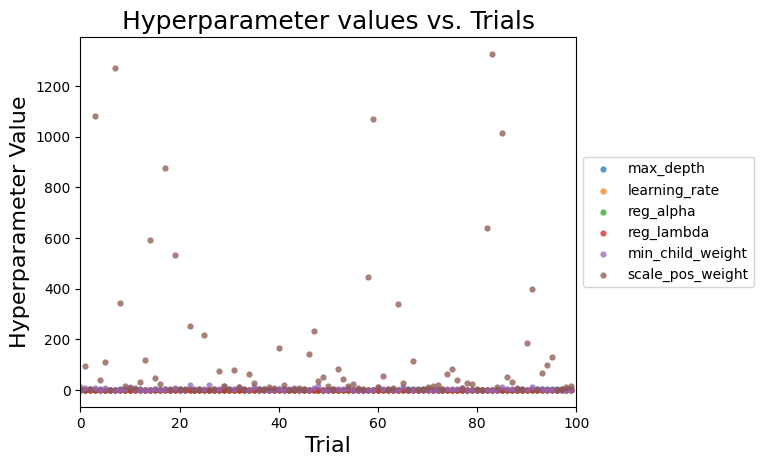

In [22]:
# Set up the figure and axis
f, ax = plt.subplots(1)

# Extract hyperparameters and corresponding trial IDs from the trials object
xs = [t['tid'] for t in trials.trials]

ys_max_depth = [t['misc']['vals']['xgbclassifier__max_depth'][0] for t in trials.trials]
ys_learning_rate = [t['misc']['vals']['xgbclassifier__learning_rate'][0] for t in trials.trials]
ys_reg_alpha = [t['misc']['vals']['xgbclassifier__reg_alpha'][0] for t in trials.trials]
ys_reg_lambda = [t['misc']['vals']['xgbclassifier__reg_lambda'][0] for t in trials.trials]
ys_min_child_weight = [t['misc']['vals']['xgbclassifier__min_child_weight'][0] for t in trials.trials]
ys_scale_pos_weight = [t['misc']['vals']['xgbclassifier__scale_pos_weight'][0] for t in trials.trials]

# Set x-axis limits to show all trials
ax.set_xlim(0, len(xs))

# Create scatter plots for each hyperparameter
ax.scatter(xs, ys_max_depth, s=20, linewidth=0.01, alpha=0.75, label='max_depth')
ax.scatter(xs, ys_learning_rate, s=20, linewidth=0.01, alpha=0.75, label='learning_rate')
ax.scatter(xs, ys_reg_alpha, s=20, linewidth=0.01, alpha=0.75, label='reg_alpha')
ax.scatter(xs, ys_reg_lambda, s=20, linewidth=0.01, alpha=0.75, label='reg_lambda')
ax.scatter(xs, ys_min_child_weight, s=20, linewidth=0.01, alpha=0.75, label='min_child_weight')
ax.scatter(xs, ys_scale_pos_weight, s=20, linewidth=0.01, alpha=0.75, label='scale_pos_weight')

# Set plot title and axis labels
ax.set_title('Hyperparameter values vs. Trials', fontsize=18)
ax.set_xlabel('Trial', fontsize=16)
ax.set_ylabel('Hyperparameter Value', fontsize=16)

# Show a legend for the different hyperparameters
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()


```
Using the best model logistic regression results:
Run ID: 33a1ead7502e43c28814a91a8fc79cf9
Start Time: 2023-08-07 12:10:27
End Time: 2023-08-07 12:10:27.312
Duration: 0.312 ms
Parameters:
logisticregression__C: 0.31303873900972606
logisticregression__class_weight: {0: 0.5003502451716202, 1: 714.2857142857143}
logisticregression__penalty: l1
Metrics:
f1_score: 1.0```




In [14]:
params = {
    'C': 0.31303873900972606,
    'class_weight': {0: 0.5003502451716202, 1: 714.2857142857143},
    'penalty': 'l1',
    'solver': 'liblinear',
    'random_state': 42
    }

mlflow.log_params(params)

# Set the hyperparameters for the logistic regression model
log_reg = LogisticRegression(**params)

# Create the pipeline with the specified hyperparameters
pipeline = make_pipeline(preprocessor, log_reg)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

probabilities = pipeline.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0, 1, 100)

scores = []

for threshold in thresholds:
    predictions = [1 if prob > threshold else 0 for prob in probabilities]
    score = f1_score(y_val, predictions)
    scores.append(score)


In [15]:
best_threshold = thresholds[np.argmax(scores)]
print(best_threshold)

0.05050505050505051


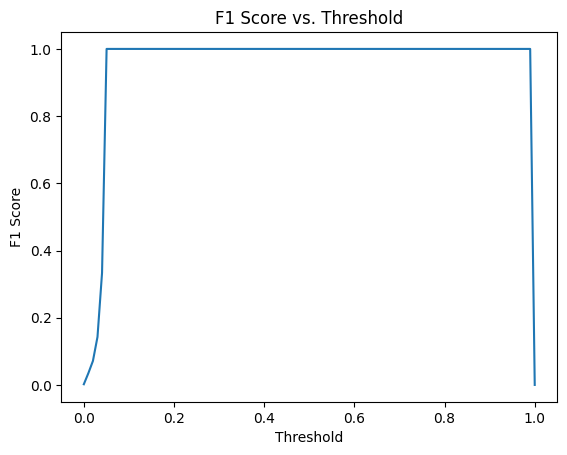

In [13]:
plt.plot(thresholds, scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.show()

In [21]:
with mlflow.start_run():

    params = {
    'C': 0.31303873900972606,
    'class_weight': {0: 0.5003502451716202, 1: 714.2857142857143},
    'penalty': 'l1',
    'solver': 'liblinear',
    'random_state': 42
    }

    mlflow.log_params(params)

    # Set the hyperparameters for the logistic regression model
    log_reg = LogisticRegression(**params)

    # Create the pipeline with the specified hyperparameters
    pipeline = make_pipeline(preprocessor, log_reg)

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Use the pipeline to make predictions using the best threshold on the test set
    y_preds = pipeline.predict_proba(X_test)[:, 1]

    # Applying the threshold
    y_preds_threshold = [1 if prob > best_threshold else 0 for prob in y_preds]

    # Calculate any metrics you want to log
    f1 = f1_score(y_test, y_preds_threshold)

    # Calculating Precision
    precision = precision_score(y_test, y_preds_threshold) 

    # Calculating Recall
    recall = recall_score(y_test, y_preds_threshold)

    print(params, f1)

    mlflow.log_metric("f1-score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

{'C': 0.31303873900972606, 'class_weight': {0: 0.5003502451716202, 1: 714.2857142857143}, 'penalty': 'l1', 'solver': 'liblinear', 'random_state': 42} 0.19999999999999998


In [22]:
experiment_id = '3'

# Retrieve a list of all runs
runs = mlflow.search_runs()

# Sort runs by start time and get the most recent run
latest_run = runs.sort_values(by="start_time", ascending=False).iloc[0]

# Print the details of the latest run
print(latest_run)

# If you only want the run_id of the latest run
latest_run_id = latest_run["run_id"]
print(f"Latest Run ID: {latest_run_id}")


run_id                                                               391dcd98e0554a62b3214dacf0ed83e0
experiment_id                                                                                       3
status                                                                                       FINISHED
artifact_uri                                        s3://mlflow-artifacts-remote-bp/3/391dcd98e055...
start_time                                                           2023-08-09 19:07:27.971000+00:00
end_time                                                             2023-08-09 19:07:32.802000+00:00
metrics.f1-score                                                                                  0.2
metrics.recall                                                                                    1.0
metrics.precision                                                                            0.111111
metrics.f1_score                                                                  

In [23]:
run_id = '391dcd98e0554a62b3214dacf0ed83e0'
model_uri = f"runs:/{run_id}/model"

model_details = mlflow.register_model(model_uri, "loan-prediction")

print(model_details)

Successfully registered model 'loan-prediction'.
2023/08/09 19:22:49 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: loan-prediction, version 1


<ModelVersion: aliases=[], creation_timestamp=1691608969439, current_stage='None', description='', last_updated_timestamp=1691608969439, name='loan-prediction', run_id='391dcd98e0554a62b3214dacf0ed83e0', run_link='', source='s3://mlflow-artifacts-remote-bp/3/391dcd98e0554a62b3214dacf0ed83e0/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>


Created version '1' of model 'loan-prediction'.


In [24]:
client = mlflow.tracking.MlflowClient()

# Transition model version to 'Staging' stage
model_version_details = client.transition_model_version_stage(
    name="loan-prediction",
    version=model_details.version,
    stage="Staging",
)
print(model_version_details)


<ModelVersion: aliases=[], creation_timestamp=1691608969439, current_stage='Staging', description='', last_updated_timestamp=1691608973404, name='loan-prediction', run_id='391dcd98e0554a62b3214dacf0ed83e0', run_link='', source='s3://mlflow-artifacts-remote-bp/3/391dcd98e0554a62b3214dacf0ed83e0/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>
